In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sksurv
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split
from sksurv.metrics import integrated_brier_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [3]:
##upload dataset ready for prediction models
#Cohort 1: clinical+GWAS+Case1
X_train_integrate_1_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_train_integrate_1_imp.csv')
X_test_integrate_1_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_test_integrate_1_imp.csv')
y_train_integrate_1= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_train_integrate_1.csv')
y_test_integrate_1= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_test_integrate_1.csv')
#Cohort 1: clinical+Case1
X_train_integrate_1cli_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_train_integrate_1cli_imp.csv')
X_test_integrate_1cli_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_test_integrate_1cli_imp.csv')
y_train_integrate_1cli= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_train_integrate_1cli.csv')
y_test_integrate_1cli= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_test_integrate_1cli.csv')
#Cohort 1: clinical+GWAS+Case2
X_train_integrate_2_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_train_integrate_2_imp.csv')
X_test_integrate_2_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_test_integrate_2_imp.csv')
y_train_integrate_2= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_train_integrate_2.csv')
y_test_integrate_2= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_test_integrate_2.csv')
#Cohort 1: clinical+Case2
X_train_integrate_2cli_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_train_integrate_2cli_imp.csv')
X_test_integrate_2cli_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_test_integrate_2cli_imp.csv')
y_train_integrate_2cli= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_train_integrate_2cli.csv')
y_test_integrate_2cli= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_test_integrate_2cli.csv')
#Cohort 2: clinical+GWAS+mRNA
X_train_overall_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_train_overall_imp.csv')
X_test_overall_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_test_overall_imp.csv')
y_train_overall= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_train_overall.csv')
y_test_overall= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_test_overall.csv')
#Cohort 2: clinical+mRNA
X_train_overall_mrna_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_train_overall_mrna_imp.csv') #1584x250
X_test_overall_mrna_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_test_overall_mrna_imp.csv') #396x250
y_train_overall_mrna= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_train_overall_mrna.csv')#1584x3
y_test_overall_mrna= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_test_overall_mrna.csv') #396x3
#Cohort 1: clinical+GWAS
X_train_integrate_gwas_imp=pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_train_integrate_gwas_imp.csv')
X_test_integrate_gwas_imp=pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_test_integrate_gwas_imp.csv')
y_train_integrate_gwas=pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_train_integrate_gwas.csv')
y_test_integrate_gwas=pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_test_integrate_gwas.csv')
#Cohort 2: clinical+GWAS
X_train_overall_gwas_imp=pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_train_overall_gwas_imp.csv')
X_test_overall_gwas_imp=pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_test_overall_gwas_imp.csv')
y_train_overall_gwas=pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_train_overall_gwas.csv')
y_test_overall_gwas=pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_test_overall_gwas.csv')

In [30]:
##elastic net with cv
def elasticnet_cox_sweep_l1_plot_cv(
        X_train: pd.DataFrame,
        X_test: pd.DataFrame,
        y_train: pd.DataFrame,
        y_test: pd.DataFrame,
        test_size: float = 0.2,
        l1_list=(0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8),
        random_state: int = 123,
        alpha_min_ratio: float = 1e-4,
        n_alphas: int = 100,
        n_time_grid: int = 100,
        coef_tol: float = 1e-12,
        k: int=5,
        feature_set: str = "full",
        title: str | None = None,
):
    # ---------------- copies ----------------
    X_train = X_train.copy()
    X_test = X_test.copy()
    y_train = y_train.copy()
    y_test = y_test.copy()

    # ---------------- OS_STATUS → numeric ----------------
    for df in (y_train, y_test):
        if "OS_STATUS_NUM" not in df.columns:
            df["OS_STATUS_NUM"] = (
                df["OS_STATUS"].astype(str)
                .str.split(":", expand=True)[0]
                .astype(int)
            )

    # ---------------- survival objects ----------------
    ytr = np.array(
        [(bool(e), float(t)) for e, t in zip(
            y_train["OS_STATUS_NUM"], y_train["OS_MONTHS"]
        )],
        dtype=[("event", "?"), ("time", "<f8")]
    )
    yte = np.array(
        [(bool(e), float(t)) for e, t in zip(
            y_test["OS_STATUS_NUM"], y_test["OS_MONTHS"]
        )],
        dtype=[("event", "?"), ("time", "<f8")]
    )

    # ---------------- build default full feature set ----------------
    cont_cols = list(range(4, 9))
    cat_cols = list(range(9, 27))
    gen_cols = list(range(27, X_train.shape[1]))

    Xtr_cont = X_train.iloc[:, cont_cols]
    Xte_cont = X_test.iloc[:, cont_cols]

    scaler_cont = StandardScaler()
    Xtr_cont_s = pd.DataFrame(scaler_cont.fit_transform(Xtr_cont), columns=Xtr_cont.columns, index=Xtr_cont.index)
    Xte_cont_s = pd.DataFrame(scaler_cont.transform(Xte_cont), columns=Xte_cont.columns, index=Xte_cont.index)

    Xtr_cat = pd.get_dummies(X_train.iloc[:, cat_cols], drop_first=True)
    Xte_cat = pd.get_dummies(X_test.iloc[:, cat_cols], drop_first=True)
    Xte_cat = Xte_cat.reindex(columns=Xtr_cat.columns, fill_value=0)

    Xtr_gen = X_train.iloc[:, gen_cols]
    Xte_gen = X_test.iloc[:, gen_cols]

    Xtr_cli = pd.concat([Xtr_cont_s, Xtr_cat], axis=1)
    Xte_cli = pd.concat([Xte_cont_s, Xte_cat], axis=1)
    Xtr_full = pd.concat([Xtr_cont_s, Xtr_cat, Xtr_gen], axis=1)
    Xte_full = pd.concat([Xte_cont_s, Xte_cat, Xte_gen], axis=1)

    fs = feature_set.lower()
    if fs in ("full", "all"):
        Xtr, Xte = Xtr_full, Xte_full
    elif fs in ("cli", "clinical"):
        Xtr, Xte = Xtr_cli, Xte_cli
    elif fs in ("gen", "genetic", "omics"):
        Xtr, Xte = Xtr_gen, Xte_gen

    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    Xtr_np = Xtr.to_numpy()

    t_min = max(ytr["time"].min(), yte["time"].min())
    t_max = min(ytr["time"].max(), yte["time"].max())
    eps = 1e-8
    times = np.linspace(t_min, t_max - eps, n_time_grid)

    rows = []
    best_overall = {"val_cindex": -np.inf}

    for l1 in l1_list:
        path_model = CoxnetSurvivalAnalysis(
            l1_ratio=float(l1),
            alpha_min_ratio=alpha_min_ratio,
            n_alphas=n_alphas
        )
        path_model.fit(Xtr_np, ytr)
        alpha_grid = path_model.alphas_
        best_alpha, best_val_ci = None, -np.inf

        for a in path_model.alphas_:
            fold_cis = []
            for tr_idx, val_idx in kf.split(Xtr_np):
                m = CoxnetSurvivalAnalysis(
                    l1_ratio=float(l1),
                    alphas=[float(a)],
                    fit_baseline_model=False)
                try:
                    m.fit(Xtr_np[tr_idx], ytr[tr_idx])
                except ArithmeticError:
                    continue

                # GUARD 1: all-zero coefficients
                if np.allclose(m.coef_, 0):
                    continue

                risk_val = m.predict(Xtr_np[val_idx])

                # GUARD 2: overflow / non-finite predictions
                if not np.all(np.isfinite(risk_val)):
                    continue

                ci = concordance_index_censored(
                    ytr[val_idx]["event"], ytr[val_idx]["time"], risk_val)[0]
                fold_cis.append(ci)

            if len(fold_cis) == 0:
                continue
            ci_mean = float(np.mean(fold_cis))
            if ci_mean > best_val_ci:
                best_val_ci, best_alpha = ci_mean, float(a)

        final_model = CoxnetSurvivalAnalysis(
            l1_ratio=float(l1),
            alphas=[best_alpha],
            fit_baseline_model=True
        )
        final_model.fit(Xtr.to_numpy(), ytr)

        # test metrics
        risk_te = final_model.predict(Xte.to_numpy())
        test_ci = concordance_index_censored(
            yte["event"], yte["time"], risk_te
        )[0]

        surv_fns = final_model.predict_survival_function(Xte.to_numpy())
        surv_te = np.vstack([fn(times) for fn in surv_fns])
        test_ibs = integrated_brier_score(ytr, yte, surv_te, times)

        n_selected = int(np.sum(np.abs(final_model.coef_.ravel()) > coef_tol))

        rows.append({
            "l1_ratio": l1,
            "val_cindex": best_val_ci,
            "test_cindex": float(test_ci),
            "test_ibs": float(test_ibs),
            "best_alpha": best_alpha,
            "n_selected": n_selected,
        })

        if best_val_ci > best_overall["val_cindex"]:
            best_overall = {
                "val_cindex": best_val_ci,
                "l1_ratio": l1,
                "alpha": best_alpha,
                "model": final_model,
            }

    results_df = pd.DataFrame(rows).sort_values("l1_ratio").reset_index(drop=True)
    best_idx = results_df["val_cindex"].idxmax()

    # plotting
    fig, ax1 = plt.subplots(figsize=(7.5, 4.5))

    x = results_df["l1_ratio"].values
    ax1.plot(x, results_df["val_cindex"], marker="o", label="Validation C-index",color="C0")
    ax1.plot(x, results_df["test_cindex"], marker="o", label="Test C-index", color="C1")
    ax1.set_xlabel("L1-ratio")
    ax1.set_ylabel("C-index")
    ax1.set_ylim(0.68, 0.72)
    ax1.grid(True, linestyle="--", alpha=0.5)

    best_l1 = results_df.loc[best_idx, "l1_ratio"]
    best_test_ci = results_df.loc[best_idx, "test_cindex"]
    best_test_ibs = results_df.loc[best_idx, "test_ibs"]
    ax1.axvline(best_l1, color="grey", linestyle="--", alpha=0.7)

    ax1.annotate(
        "Best val",
        xy=(results_df.loc[best_idx, "l1_ratio"],
            results_df.loc[best_idx, "val_cindex"]),
        xytext=(5, 5),
        textcoords="offset points"
    )

    ax2 = ax1.twinx()
    ax2.plot(x, results_df["test_ibs"], marker="o", label="Test IBS", color="C2")
    ax2.set_ylabel("IBS")

    ax1.annotate(
        f"Test C-index={best_test_ci:.3f}\nTest IBS={best_test_ibs:.3f}",
        xy=(best_l1, ax1.get_ylim()[0]),      # anchor at bottom of ax1
        xytext=(6, 32),
        textcoords="offset points",
        ha="left", va="bottom",
        color="grey")


    if title is not None:
        ax1.set_title(title)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

    fig.tight_layout()
    return results_df, best_overall, fig,final_model


/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/2282772123.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/2282772123.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/2282772123.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/2282772123.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/2282772123.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/2

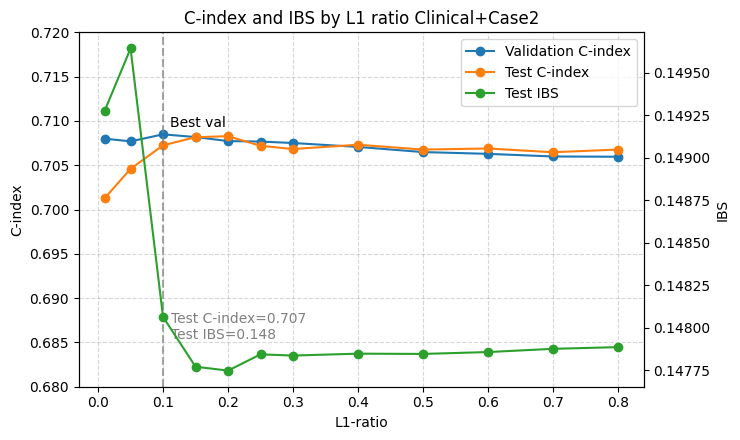

In [31]:
#Cohort1: Clinical+Case2
results_integrate_2cli, best_integrate_2cli, fig_integrate_2cli, final_model = elasticnet_cox_sweep_l1_plot_cv(
X_train = X_train_integrate_2cli_imp,
X_test = X_test_integrate_2cli_imp,
y_train = y_train_integrate_2cli,
y_test = y_test_integrate_2cli,
title = "C-index and IBS by L1 ratio Clinical+Case2"
)

In [ ]:
#Cohort1: Clinical+GWAS+Case1
results_integrate_1_all, best_integrate_1_all, fig_integrate_1_all, final_model=elasticnet_cox_sweep_l1_plot_cv(
    X_train=X_train_integrate_1_imp,
    X_test=X_test_integrate_1_imp,
    y_train=y_train_integrate_1,
    y_test=y_test_integrate_1,
    title="Cohort1: Clinical+GWAS+Case1"
)

/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: ConvergenceWarning: Optimization terminated early, you migh

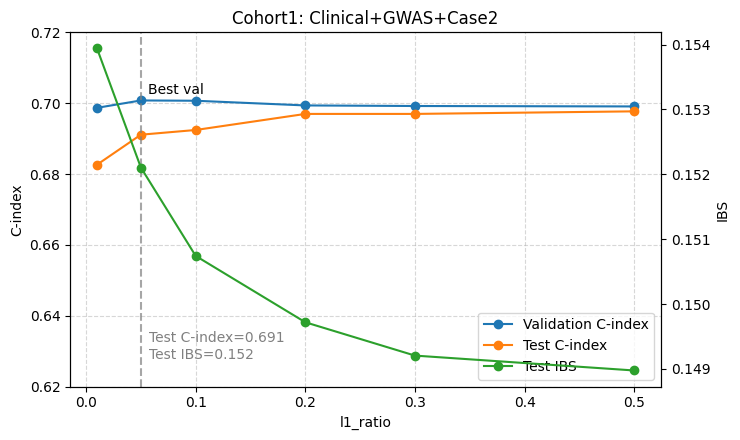

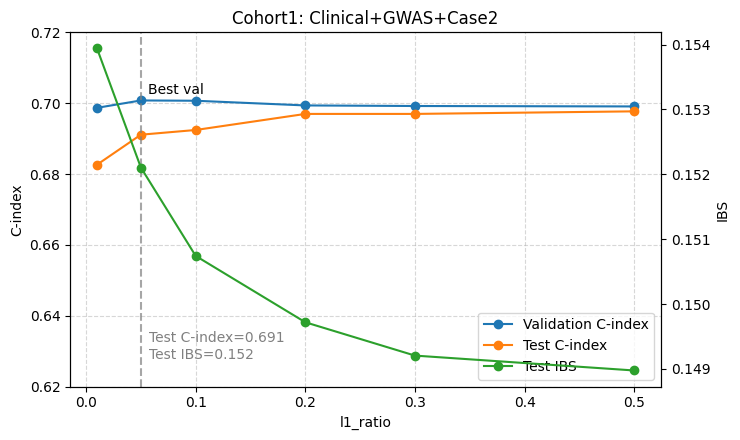

In [12]:
#Cohort1: Clinical+GWAS+Case2
results_integrate_2_all, best_integrate_2_all, fig_integrate_2_all, final_model=elasticnet_cox_sweep_l1_plot_cv(
    X_train=X_train_integrate_2_imp,
    X_test=X_test_integrate_2_imp,
    y_train=y_train_integrate_2,
    y_test=y_test_integrate_2,
    k=3,
    n_alphas= 30,
    l1_list=(0.01, 0.05, 0.1, 0.2, 0.3, 0.5),
    title="Cohort1: Clinical+GWAS+Case2"
)
fig_integrate_2_all

/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3

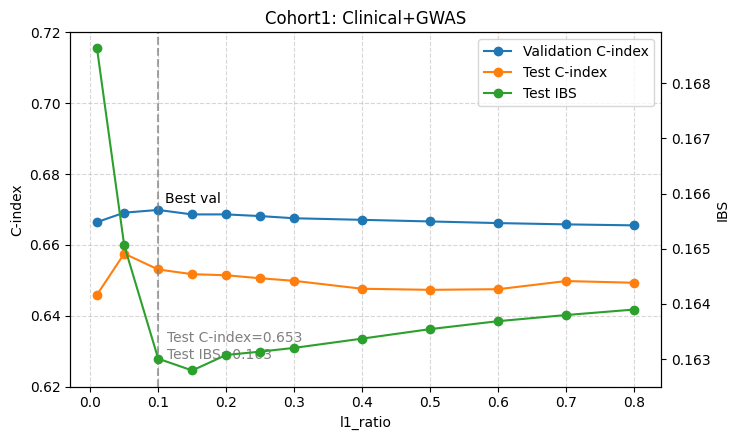

In [13]:
#Cohort1: Clinical+GWAS
results_integrate_gwas, best_integrate_gwas, fig_integrate_gwas, final_model=elasticnet_cox_sweep_l1_plot_cv(
    X_train=X_train_integrate_gwas_imp,
    X_test=X_test_integrate_gwas_imp,
    y_train=y_train_integrate_gwas,
    y_test=y_test_integrate_gwas,
    title="Cohort1: Clinical+GWAS"
)

/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3

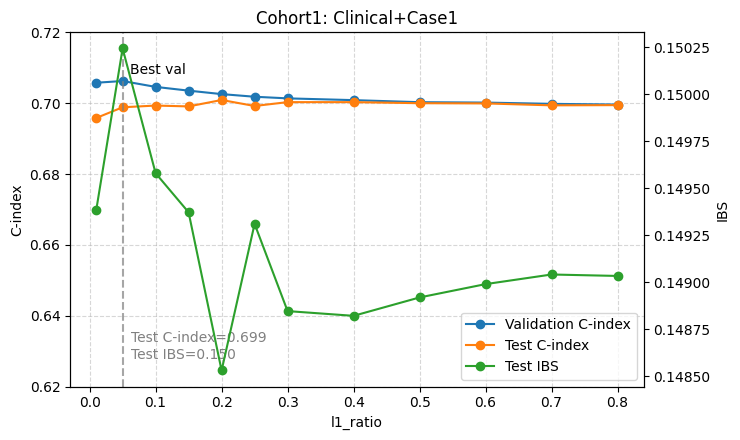

In [14]:
#Cohort1: Clinical+Case1
results_integrate_1cli, best_integrate_1cli, fig_integrate_1cli, final_model=elasticnet_cox_sweep_l1_plot_cv(
    X_train=X_train_integrate_1cli_imp,
    X_test=X_test_integrate_1cli_imp,
    y_train=y_train_integrate_1cli,
    y_test=y_test_integrate_1cli,
    title="Cohort1: Clinical+Case1"
)

/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3

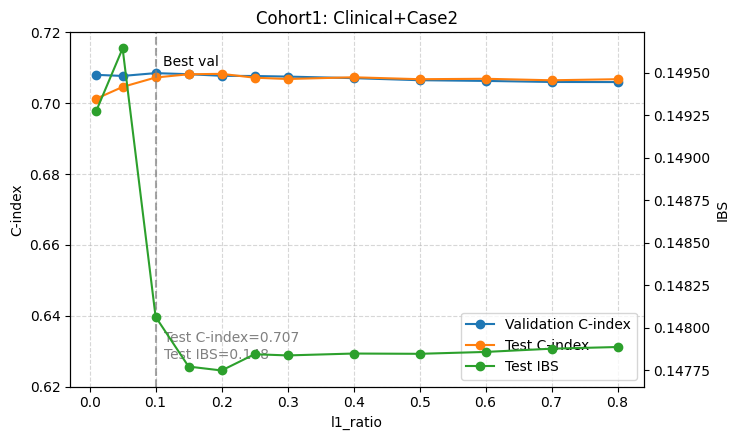

In [15]:
#Cohort1: Clinical+Case2
results_integrate_2cli, best_integrate_2cli, fig_integrate_2cli, final_model=elasticnet_cox_sweep_l1_plot_cv(
    X_train=X_train_integrate_2cli_imp,
    X_test=X_test_integrate_2cli_imp,
    y_train=y_train_integrate_2cli,
    y_test=y_test_integrate_2cli,
    title="C-index and IBS by L1 ratio Clinical+Case2"
)

/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3

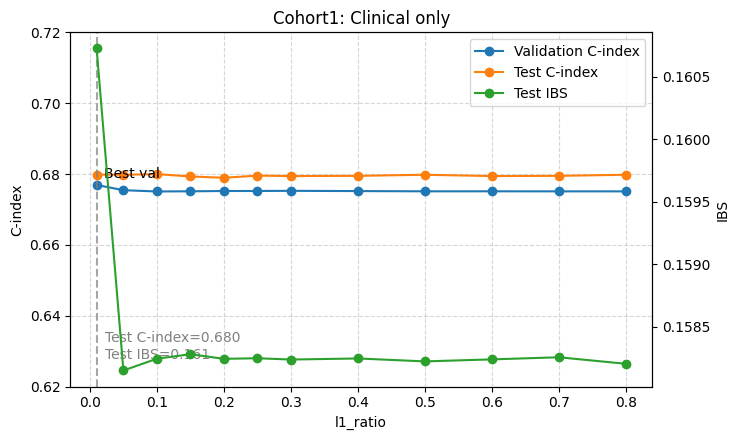

In [16]:
#Cohort1: Clinical only
results_integrate_cli, best_integrate_cli, fig_integrate_cli, final_model=elasticnet_cox_sweep_l1_plot_cv(
    X_train=X_train_integrate_2cli_imp,
    X_test=X_test_integrate_2cli_imp,
    y_train=y_train_integrate_2cli,
    y_test=y_test_integrate_2cli,
    feature_set='cli',
    title="Cohort1: Clinical only"
)

/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3

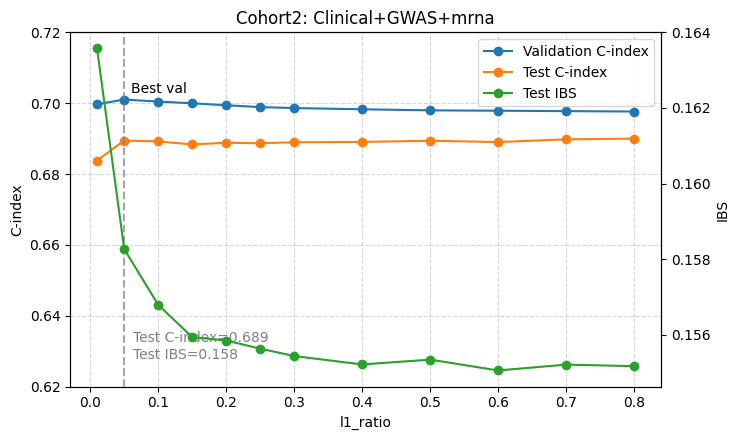

In [17]:
#Cohort2: Clinical+GWAS+mRNA+GWAS
results_overall_all, best_overall_all, fig_overall_all, final_model=elasticnet_cox_sweep_l1_plot_cv(
    X_train=X_train_overall_imp,
    X_test=X_test_overall_imp,
    y_train=y_train_overall,
    y_test=y_test_overall,
    title="Cohort2: Clinical+GWAS+mrna"
)

/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3

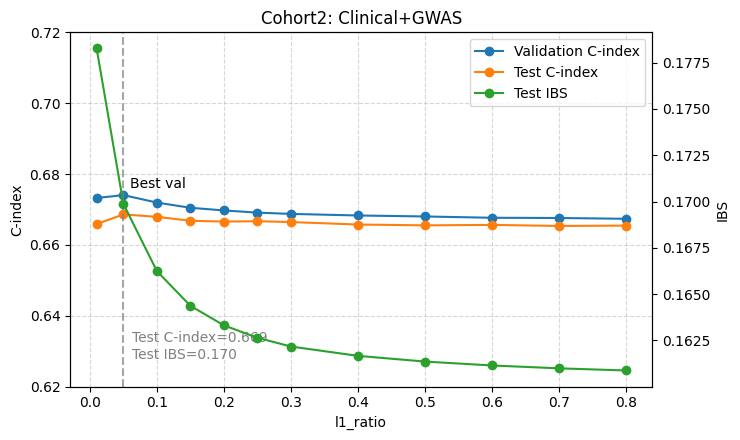

In [18]:
#Cohort2: Clinical+GWAS
results_overall_gwas, best_overall_gwas, fig_overall_gwas, final_model=elasticnet_cox_sweep_l1_plot_cv(
    X_train=X_train_overall_gwas_imp,
    X_test=X_test_overall_gwas_imp,
    y_train=y_train_overall_gwas,
    y_test=y_test_overall_gwas,
    title="Cohort2: Clinical+GWAS"
)

/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3790853141.py:112: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1404/3

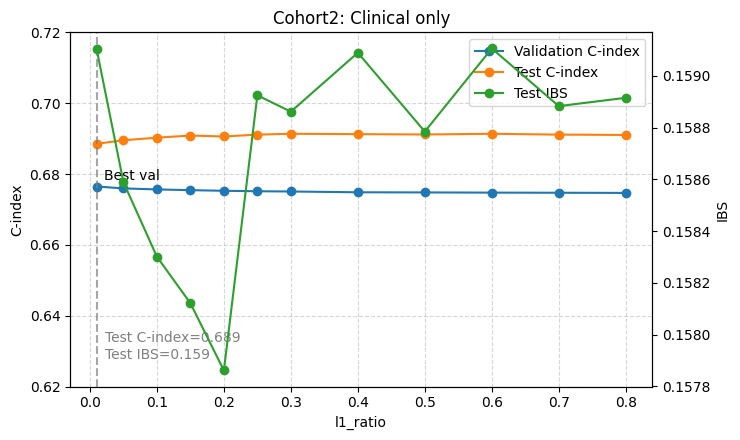

In [19]:
#Cohort2: Clinical only
results_overall_cli, best_overall_cli, fig_overall_cli, final_model=elasticnet_cox_sweep_l1_plot_cv(
    X_train=X_train_overall_gwas_imp,
    X_test=X_test_overall_gwas_imp,
    y_train=y_train_overall_gwas,
    y_test=y_test_overall_gwas,
    feature_set='cli',
    title="Cohort2: Clinical only"
)

/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_14164/1389552466.py:111: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_14164/1389552466.py:111: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_14164/1389552466.py:111: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_14164/1389552466.py:111: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_14164/1389552466.py:111: UserWarning: all coefficients are zero, consider decreasing alpha.
  m.fit(Xtr_np[tr_idx], ytr[tr_idx])
/var/folders/gs/ry92bp917ls0kvm5jg1c9l900000gq/T/ipykernel_1

    l1_ratio  val_cindex  test_cindex  test_ibs  best_alpha  n_selected
0       0.01    0.676476     0.688528  0.159105    0.021479          46
1       0.05    0.675945     0.689529  0.158590    0.019033          43
2       0.10    0.675654     0.690263  0.158301    0.013807          41
3       0.15    0.675448     0.690863  0.158122    0.011087          39
4       0.20    0.675269     0.690596  0.157861    0.010992          34
5       0.25    0.675140     0.691130  0.158925    0.003807          39
6       0.30    0.675074     0.691363  0.158862    0.003481          38
7       0.40    0.674845     0.691263  0.159090    0.002379          36
8       0.50    0.674809     0.691163  0.158785    0.002516          36
9       0.60    0.674751     0.691363  0.159106    0.001741          36
10      0.70    0.674716     0.691130  0.158883    0.001797          36
11      0.80    0.674670     0.691030  0.158916    0.001573          36
{'val_cindex': 0.6764764715563275, 'l1_ratio': 0.01, 'alpha': 0.

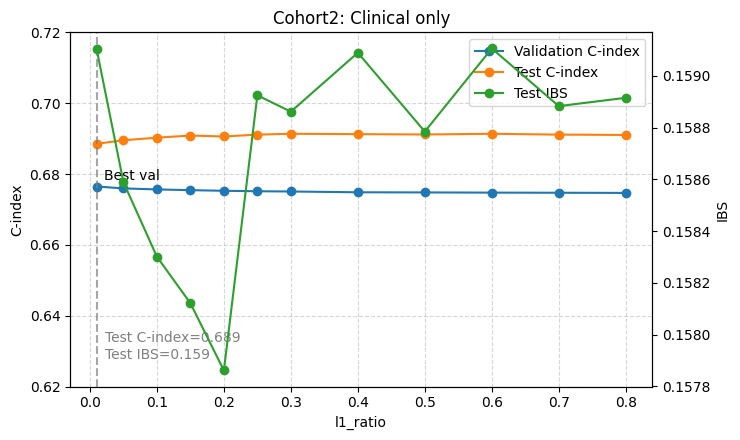

In [318]:
results_df_overall_cli, best_overall, fig, final_model=elasticnet_cox_sweep_l1_plot_cv(
    X_train=X_train_overall_imp,
    X_test=X_test_overall_imp,
    y_train=y_train_overall,
    y_test=y_test_overall,
    feature_set='cli',
    title="Cohort2: Clinical only"
)
print(results_df_overall_cli)
print(best_overall)

/Users/mac1/PyCharmMiscProject/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but CoxnetSurvivalAnalysis was fitted without feature names
  warnings.warn(
/Users/mac1/PyCharmMiscProject/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but CoxnetSurvivalAnalysis was fitted without feature names
  warnings.warn(


Text(0, 0.5, 'Survival probability')

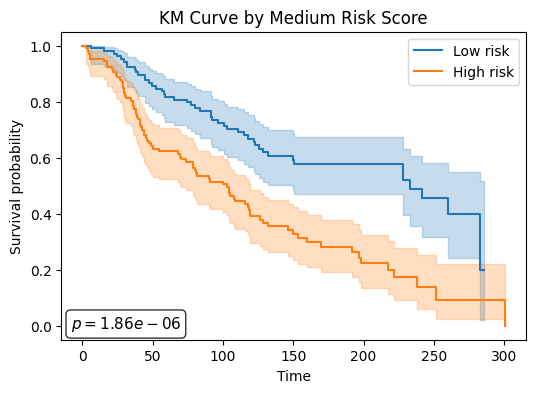

In [75]:
#risk score of optimal model
X_train=X_train_integrate_2cli_imp
X_test=X_test_integrate_2cli_imp
y_train=y_train_integrate_2cli
y_test=y_test_integrate_2cli
#Convert OS_STATUS → numeric event indicator
y_train["OS_STATUS_NUM"] = (
    y_train["OS_STATUS"]
    .str.split(":", expand=True)[0]
    .astype(int)
)
y_test["OS_STATUS_NUM"] = (
    y_test["OS_STATUS"]
    .str.split(":", expand=True)[0]
    .astype(int)
)

cont_cols = list(range(4, 9))
cat_cols  = list(range(9, 27))
gen_cols  = list(range(27, X_train.shape[1]))

Xtr_cont = X_train.iloc[:, cont_cols].copy()
Xte_cont = X_test.iloc[:,  cont_cols].copy()
#one-hot
Xtr_cat = pd.get_dummies(X_train.iloc[:, cat_cols],drop_first=True)
Xte_cat = pd.get_dummies(X_test.iloc[:, cat_cols],drop_first=True)
Xte_cat = Xte_cat.reindex(columns=Xtr_cat.columns, fill_value=0)
Xtr_gen = X_train.iloc[:, gen_cols].copy()
Xte_gen = X_test.iloc[:,  gen_cols].copy()

#Combine
Xtr_full = pd.concat([Xtr_cont, Xtr_cat, Xtr_gen], axis=1)
Xte_full = pd.concat([Xte_cont, Xte_cat, Xte_gen], axis=1)

#Build survival objects (scikit-survival format)
ytr = np.array(
    [(bool(e), t) for e, t in zip(
        y_train["OS_STATUS_NUM"].values,
        y_train["OS_MONTHS"].values
    )],
    dtype=[("event", "?"), ("time", "<f8")]) #1133 x 2

yte = np.array(
    [(bool(e), t) for e, t in zip(
        y_test["OS_STATUS_NUM"].values,
        y_test["OS_MONTHS"].values
    )],
    dtype=[("event", "?"), ("time", "<f8")]) #284 x 2

#validation set
idx = np.arange(X_train.shape[0])
idx_tr, idx_val = train_test_split(idx, test_size=0.2, random_state=123) #1267+317
ytr_in  = ytr[idx_tr]
ytr_val = ytr[idx_val]

#create risk score based on training data
risk_train = final_model.predict(Xtr_full)
risk_test  = final_model.predict(Xte_full)
threshold = np.median(risk_train)
risk_group_test = (risk_test > threshold).astype(int)


from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

kmf = KaplanMeierFitter()

T = yte["time"]
E = yte["event"]

fig_risk, ax_left = plt.subplots(figsize=(6,4))

for grp, label in zip([0,1], ["Low risk", "High risk"]):
    ix = risk_group_test == grp
    kmf.fit(T[ix], E[ix], label=label)
    kmf.plot_survival_function(ax=ax_left)

# log-rank
res = logrank_test(
    T[risk_group_test==0], T[risk_group_test==1],
    E[risk_group_test==0], E[risk_group_test==1]
)
ax_left.text(
    0.02, 0.02,
    f"$p = {res.p_value:.3g}$",
    transform=ax_left.transAxes,
    ha="left",
    va="bottom",
    fontsize=11,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)
#(log-rank p={res.p_value:.3g})
ax_left.set_title(f"KM Curve by Medium Risk Score")
ax_left.set_xlabel("Time")
ax_left.set_ylabel("Survival probability")

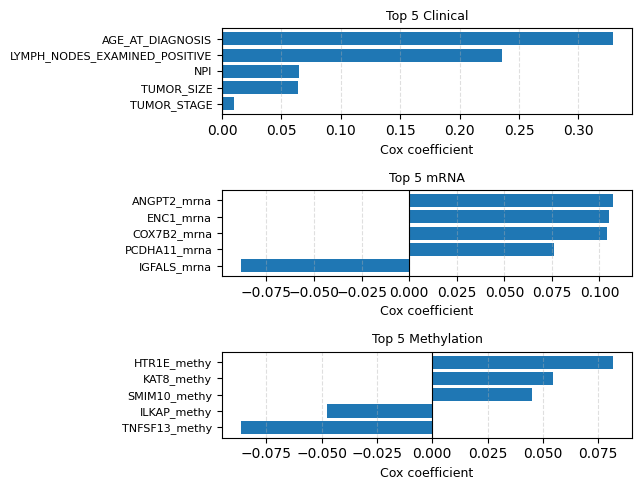

In [69]:
##select top features
coef = pd.Series(
    final_model.coef_.ravel(),
    index=Xtr_full.columns,
    name="coef"
)

coef_df = coef.to_frame()
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df["selected"] = coef_df["abs_coef"] > 1e-8

coef_df["category"] = "Clinical"
coef_df.loc[coef_df.index.str.endswith("_mrna"), "category"] = "mRNA"
coef_df.loc[coef_df.index.str.endswith("_methy"), "category"] = "Methylation"

summary = (
    coef_df[coef_df["selected"]]
    .groupby("category")
    .agg(
        n_selected=("coef", "size"),
        mean_abs_coef=("abs_coef", "mean")
    )
)

# only selected features
sel = coef_df[coef_df["selected"]]

# summary counts
summary = sel.groupby("category").size()

# top 5 per category
top5_dict = {}
for cat in ["Clinical", "mRNA", "Methylation"]:
    top5 = (
        sel[sel["category"] == cat]
        .sort_values("abs_coef", ascending=False)
        .head(5)
        .sort_values("coef")   # nicer horizontal bars
    )
    top5_dict[cat] = top5


import matplotlib.pyplot as plt

fig_top = plt.figure(figsize=(12, 5))
gs = fig_top.add_gridspec(
    nrows=3, ncols=2,
    width_ratios=[1.3, 1],
    height_ratios=[1, 1, 1]
)


categories = ["Clinical", "mRNA", "Methylation"]

for i, cat in enumerate(["Clinical", "mRNA", "Methylation"]):
    ax = fig_top.add_subplot(gs[i, 1])
    top5 = top5_dict[cat]

    if not top5.empty:
        ax.barh(top5.index, top5["coef"])
        ax.axvline(0, color="black", linewidth=0.8)

    ax.set_title(f"Top 5 {cat}", fontsize=9)
    ax.set_xlabel("Cox coefficient",fontsize=9)
    ax.tick_params(axis="y", labelsize=8)
    ax.grid(True, axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

Number of common Top-150 features: 33


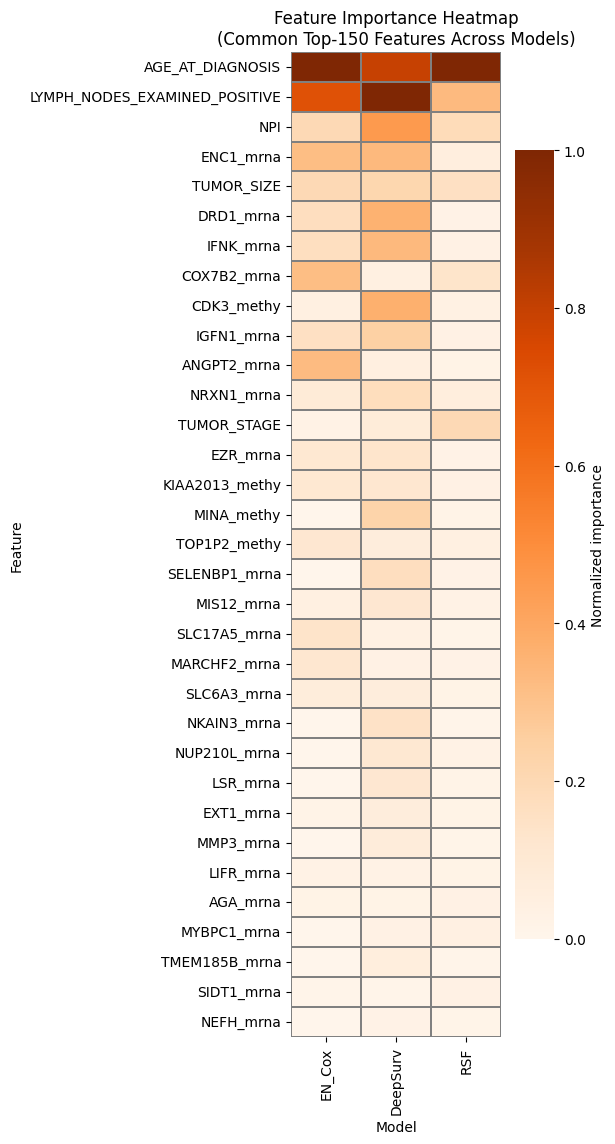

In [65]:
##heatmap
import seaborn as sns

imp_en  = pd.read_csv("/Users/mac1/Desktop/elasticnet_cox_importance.txt", sep="\t")
imp_ds  = pd.read_csv("/Users/mac1/Desktop/deepsurv_permutation_importance.txt", sep="\t")
imp_rsf = pd.read_csv("/Users/mac1/Desktop/rsf_permutation_importance.txt", sep="\t")

imp_en  = imp_en.rename(columns={"importance": "EN_Cox"})
imp_ds  = imp_ds.rename(columns={"importance": "DeepSurv"})
imp_rsf = imp_rsf.rename(columns={"importance": "RSF"})

# merge on feature
imp_all = (
    imp_en
    .merge(imp_ds, on="feature", how="outer")
    .merge(imp_rsf, on="feature", how="outer")
)

# Fill missing with 0
imp_all = imp_all.fillna(0.0)


imp_norm = imp_all.copy()

for col in ["EN_Cox", "DeepSurv", "RSF"]:
    max_val = imp_norm[col].max()
    if max_val > 0:
        imp_norm[col] = imp_norm[col] / max_val


######## Num of Features #########
TOP_K = 150

top_en = set(
    imp_norm.sort_values("EN_Cox", ascending=False)
            .head(TOP_K)["feature"]
)

top_ds = set(
    imp_norm.sort_values("DeepSurv", ascending=False)
            .head(TOP_K)["feature"]
)

top_rsf = set(
    imp_norm.sort_values("RSF", ascending=False)
            .head(TOP_K)["feature"]
)

# Intersection
common_features = top_en & top_ds & top_rsf
print(f"Number of common Top-{TOP_K} features:", len(common_features))


imp_plot = (
    imp_norm
    .loc[imp_norm["feature"].isin(common_features)]
    .set_index("feature")
    [["EN_Cox", "DeepSurv", "RSF"]]
)

# Sort by mean importance (optional, nicer ordering)
imp_plot["mean_importance"] = imp_plot.mean(axis=1)
imp_plot = imp_plot.sort_values("mean_importance", ascending=False)
imp_plot = imp_plot.drop(columns="mean_importance")


# Plot heatmap
fig_heatmap2=plt.figure(figsize=(6, 0.35 * len(imp_plot)))

ax = sns.heatmap(
    imp_plot,
    cmap="Oranges",
    vmin=0,
    linewidths=0.3,
    linecolor="grey",
    cbar_kws={"label": "Normalized importance"}
)

ax.set_xlabel("Model")
ax.set_ylabel("Feature")

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    ha="center",
    va="top"
)

plt.title(f"Feature Importance Heatmap\n(Common Top-{TOP_K} Features Across Models)")
plt.tight_layout()

plt.savefig(
    "feature_importance_heatmap_common_top50_new.jpeg",
    dpi=300,
    bbox_inches="tight",
    format="jpeg"
)

plt.show()

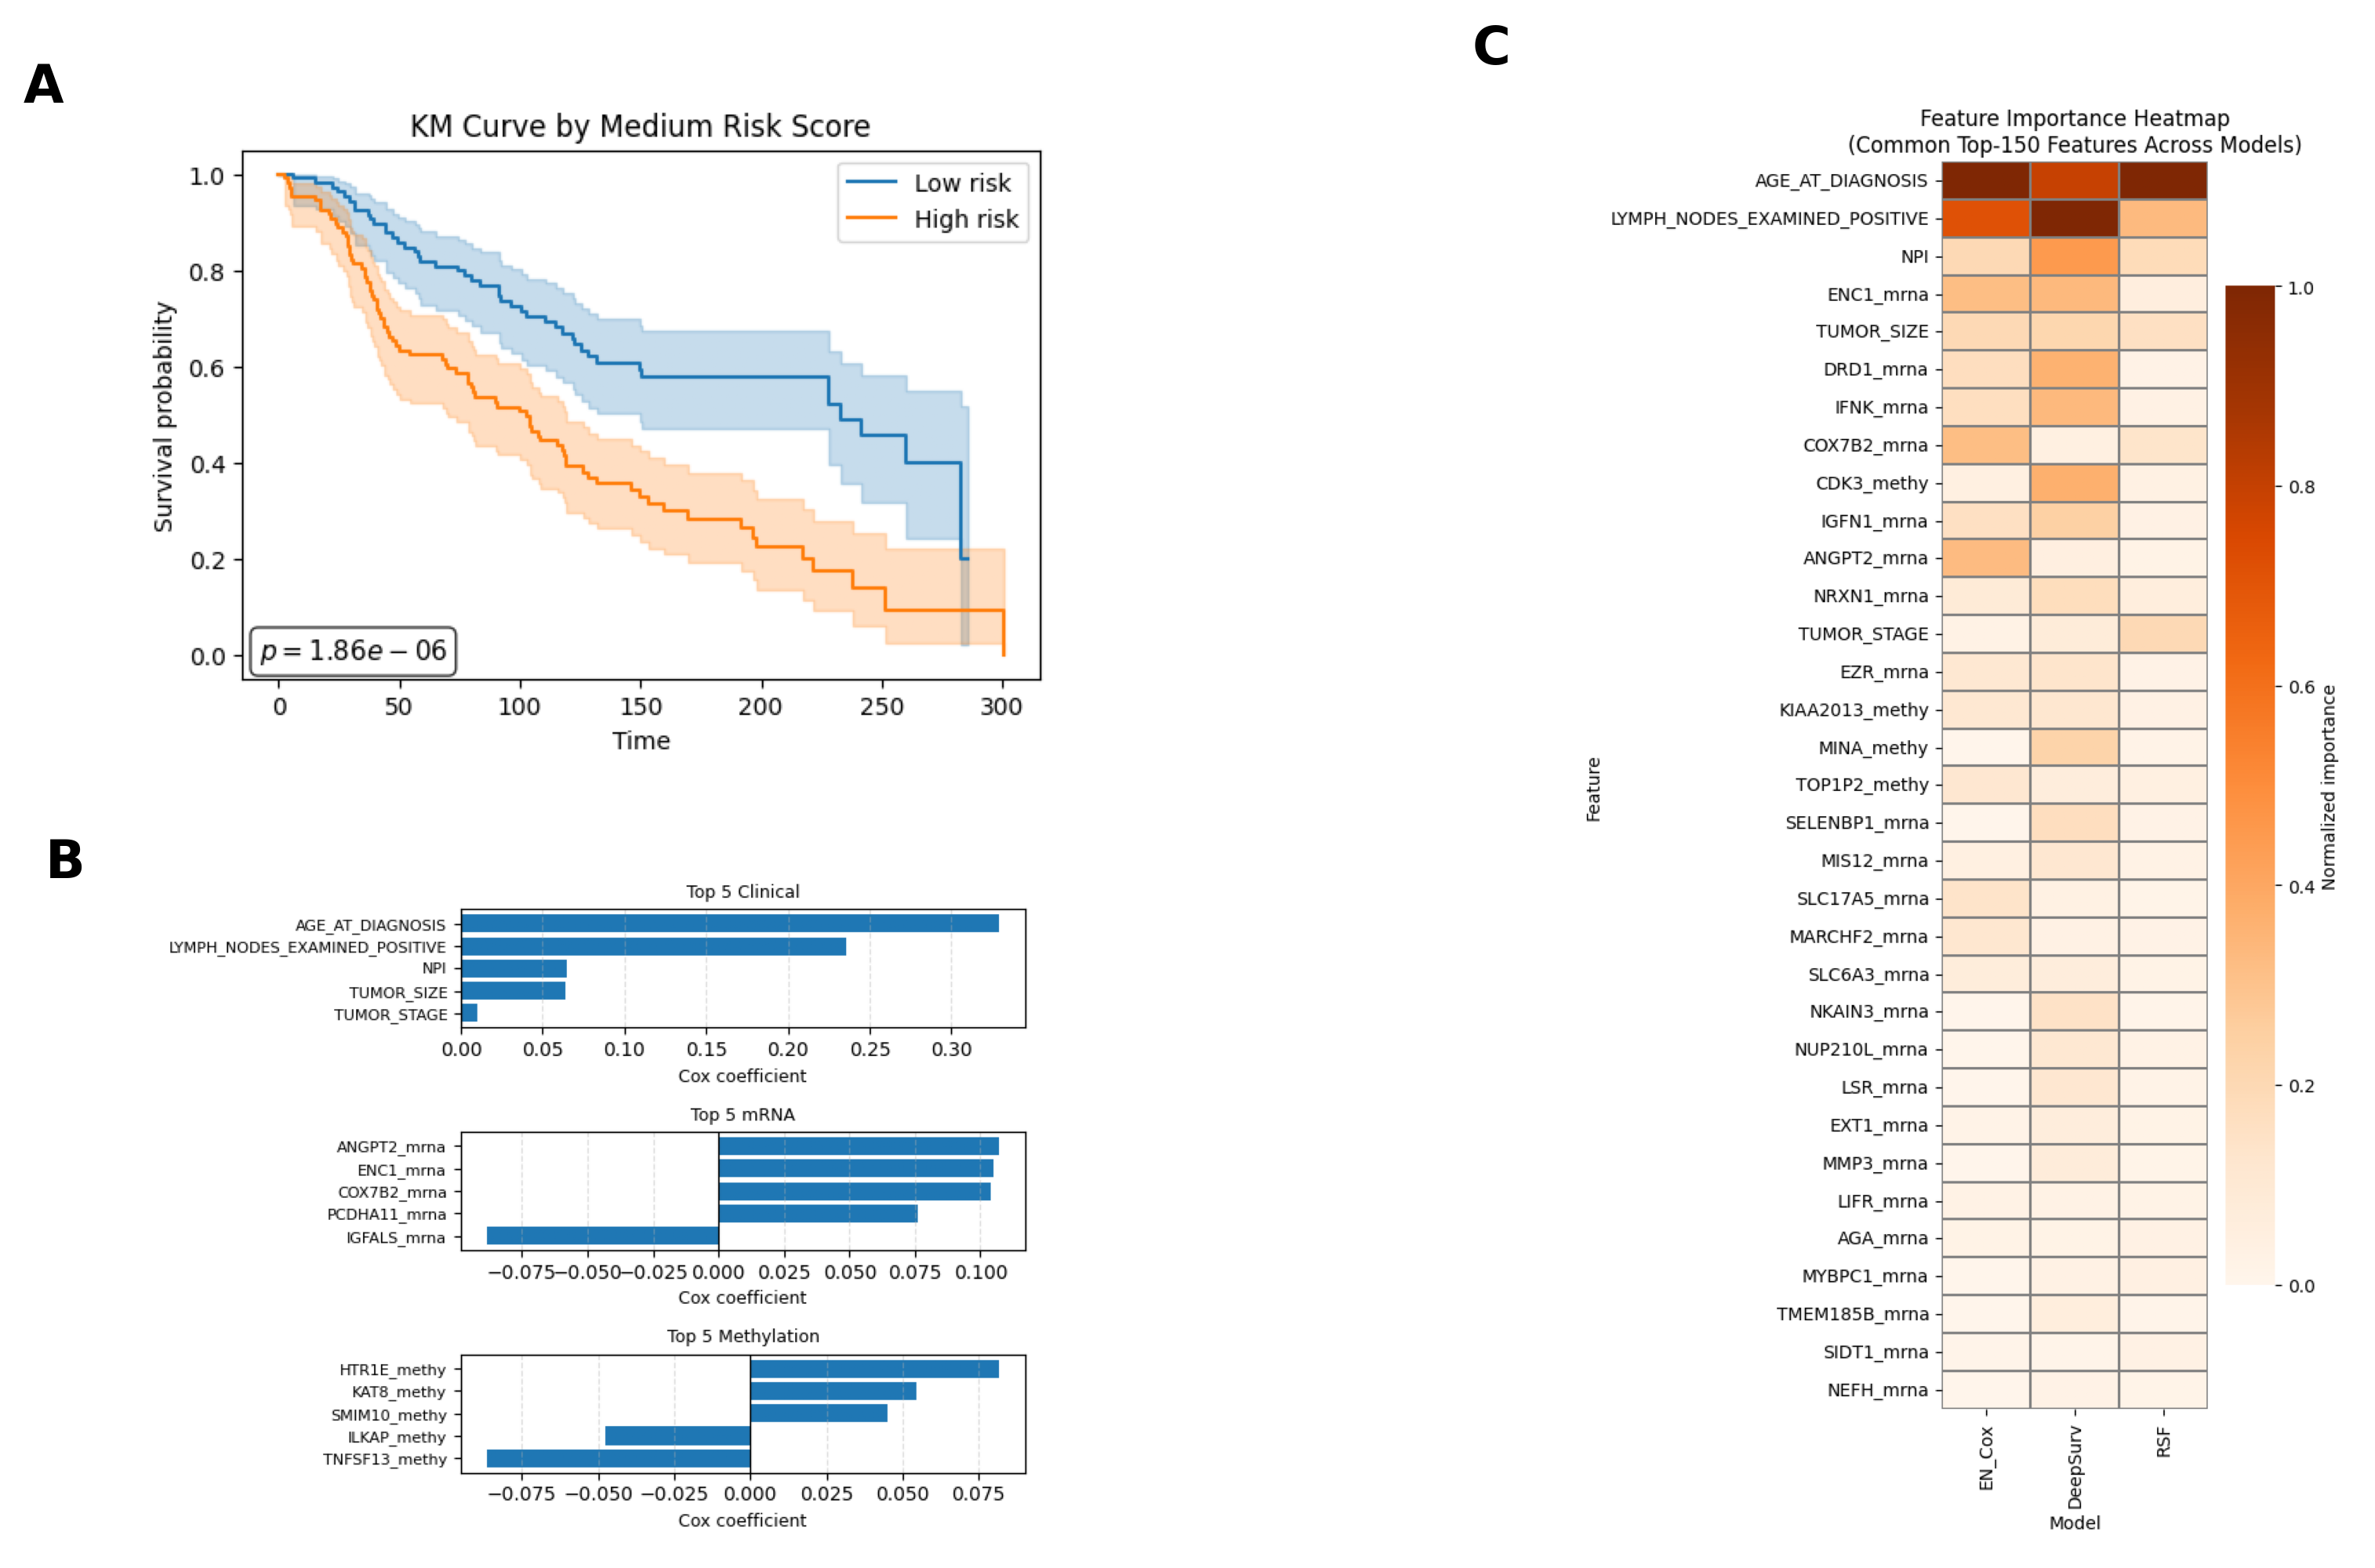

In [82]:
##combine three into Figure2
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
# save figures you want to keep
fig_risk.savefig("fA.png", bbox_inches="tight")      # old B → new A
fig_top.savefig("fB.png", bbox_inches="tight")       # old C → new B
fig_heatmap2.savefig("fC.png", bbox_inches="tight")  # old D → new C

# load images
imgA = mpimg.imread("fA.png")
imgB = mpimg.imread("fB.png")
imgC = mpimg.imread("fC.png")

# figure layout
fig = plt.figure(figsize=(14, 8), dpi=300)
gs = GridSpec(
    nrows=2,
    ncols=2,
    width_ratios=[1.1, 0.9],   # right column slightly narrower (good for heatmap)
    height_ratios=[1, 1],
    hspace=0.15,
    wspace=0.15
)

# axes
axA = fig.add_subplot(gs[0, 0])   # A: KM curve
axB = fig.add_subplot(gs[1, 0])   # B: coefficients
axC = fig.add_subplot(gs[:, 1])   # C: heatmap (span rows)

# plot images
for ax, img in zip([axA, axB, axC], [imgA, imgB, imgC]):
    ax.imshow(img)
    ax.axis("off")

# panel labels
for ax, lab in zip([axA, axB, axC], ["A", "B", "C"]):
    ax.text(
        -0.08, 1.05,
        lab,
        transform=ax.transAxes,
        fontsize=16,
        fontweight="bold",
        va="top",
        ha="right"
    )

plt.show()